# What's the Most Consistent Happy Country?
## Summer 2024 Data Science Project

**By Matvey Lyapin.**

### Introduction

Some parts of the world contain people that are generally happy, and other parts of the world contain people that are generally not so happy. Unfortunately, this is currently the state of human affairs. Fortunately, there are some meaningful questions we can ask about this state of human affairs; questions that, if answered, can help anyone -- from world leaders to next-door neighbors -- make informed decisions to manifest a better world. Which regions of the world are happiest? Which large-scale factors correlate with a region's happiness? Are differences in happiness between countries even that large? And -- most importantly for our purposes -- can it be predicted? In this tutorial, we will demonstrate the ebbs and flows of the data science lifecycle by taking a statistical approach to these tough questions, with a little help from the [World Happiness Report](https://worldhappiness.report/).

### Data Curation

Data Sources:
1. Helliwell, J. F., Layard, R., Sachs, J. D., De Neve, J.-E., Aknin, L. B., & Wang, S. (Eds.), Data for Table 2.1. (2024). *World Happiness Report 2024* \[Data File]. Retrieved from https://worldhappiness.report/ed/2024/#appendices-and-data:~:text=for%20Figure%202.1-,Data%20for%20Table%202.1,-Chapter%203%20Appendix.
2. World Bank, World Development Indicators. (2024). *World Development Indicators* (28) \[Data file]. Retrieved from https://datacatalog.worldbank.org/search/dataset/0037712.


First, let's import all the python libraries that we're going to need for this tutorial.
- I'm doing this in one cell up-front since I know which ones I need ahead of time, but in a realistic situation you'd usually add them as you go along and as you gradually figure out what functionality you require. 
- In fact, that last point really goes for most of this tutorial. Just because I'm feeding you code in perfect atomic sequential little blocks doesn't mean that it was actually *written* that way, or that it "should be" written that way; quite the contrary! Always remember that code is almost *never* written sequentially!

In [101]:
## Import important stuff.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator # for plots in Visualization
import scipy.stats as statsim
from sklearn.linear_model import LinearRegression # for Primary Analysis
from sklearn.metrics import mean_squared_error, r2_score # for Primary Analysis
from math import ceil, floor

Let's now import the World Happiness Report Excel sheet into a dataframe, and have a look at it.

In [239]:
xlsx = pd.ExcelFile("datasets/whr/src/WHR_Tab2.1.xls") # relative path to data
whole_whr = pd.read_excel(xlsx, "Sheet1") # yoink Sheet1 of Excel Spreadsheet
print(whole_whr)

     Country name  year  Life Ladder  Log GDP per capita  Social support  \
0     Afghanistan  2008     3.723590            7.350416        0.450662   
1     Afghanistan  2009     4.401778            7.508646        0.552308   
2     Afghanistan  2010     4.758381            7.613900        0.539075   
3     Afghanistan  2011     3.831719            7.581259        0.521104   
4     Afghanistan  2012     3.782938            7.660506        0.520637   
...           ...   ...          ...                 ...             ...   
2358     Zimbabwe  2019     2.693523            7.697755        0.759162   
2359     Zimbabwe  2020     3.159802            7.596050        0.717243   
2360     Zimbabwe  2021     3.154578            7.656878        0.685151   
2361     Zimbabwe  2022     3.296220            7.670073        0.666172   
2362     Zimbabwe  2023     3.572386            7.678590        0.693817   

      Healthy life expectancy at birth  Freedom to make life choices  \
0              

Interesting! But we don't really care about anything other than the 'Country name', 'year', and 'Life Ladder' columns, so we're gonna drop them.

In [14]:
whr = whole_whr[['Country name', 'year', 'Life Ladder']]
print(whr)

     Country name  year  Life Ladder
0     Afghanistan  2008     3.723590
1     Afghanistan  2009     4.401778
2     Afghanistan  2010     4.758381
3     Afghanistan  2011     3.831719
4     Afghanistan  2012     3.782938
...           ...   ...          ...
2358     Zimbabwe  2019     2.693523
2359     Zimbabwe  2020     3.159802
2360     Zimbabwe  2021     3.154578
2361     Zimbabwe  2022     3.296220
2362     Zimbabwe  2023     3.572386

[2363 rows x 3 columns]


In [238]:
ll = whr.pivot(index='Country name', columns='year', values='Life Ladder')
print(ll)

year              2005      2006      2007      2008      2009      2010  \
Country name                                                               
Afghanistan        NaN       NaN       NaN  3.723590  4.401778  4.758381   
Albania            NaN       NaN  4.634252       NaN  5.485470  5.268937   
Algeria            NaN       NaN       NaN       NaN       NaN  5.463567   
Angola             NaN       NaN       NaN       NaN       NaN       NaN   
Argentina          NaN  6.312925  6.073158  5.961034  6.424133  6.441067   
...                ...       ...       ...       ...       ...       ...   
Venezuela     7.169621  6.525146       NaN  6.257771  7.188803  7.478455   
Vietnam            NaN  5.293660  5.421688  5.480425  5.304265  5.295781   
Yemen              NaN       NaN  4.477133       NaN  4.809259  4.350313   
Zambia             NaN  4.824455  3.998293  4.730263  5.260361       NaN   
Zimbabwe           NaN  3.826268  3.280247  3.174264  4.055914  4.681570   

year       

### Exploratory Data Analysis

### Primary Analysis

Now that we've gotten a feel for the data, let's take a crack at building models that predict the future happiness of different countries. We start with a relatively simple class that takes in a country from our dataset and fits a Simple Linear Regression (SLR) to it.

In [236]:
class HapModel:
    def __init__(self, country):
        country_whr = whr[whr['Country name'] == country]

        self.name = country
        self.X = country_whr['year'].to_numpy().reshape(-1, 1)
        self.y = country_whr['Life Ladder'].to_numpy().reshape(-1, 1)
        self.model = LinearRegression().fit(self.X, self.y)
        self.y_pred = self.model.predict(self.X)
        self.mse = mean_squared_error(self.y, self.y_pred)
        self.r2 = r2_score(self.y, self.y_pred)

    def transform_axes(self, axes):
        axes.scatter(self.X, self.y, color='blue', label='Data')
        axes.plot(self.X, self.y_pred, color='red', label='Linear Regression')
        axes.xaxis.set_major_locator(MaxNLocator(integer=True))
        axes.set_title(f'{self.name}\'s Life Ladder Over Time (R2={"{:.7f}".format(self.r2)})')
        axes.set_ylabel('Life Ladder Score')
        axes.set_xlabel('Year')
        axes.legend()

    def report(self):
        fig, axes = plt.subplots()
        self.transform_axes(axes)
        plt.show()
    
    def predict_happiness(self, year):
        return self.model.predict([[year]]).clip(min=0)[0][0]

    def display_happy_pred(self, year):
        print(f'In {year}, {self.name}\'s Life Ladder score is projected to be {self.predict_happiness(year)}!')

In [152]:
def get_prediction_table(year):
    slindex = ll.dropna(subset=[2021, 2022, 2023]).index.to_numpy()
    d = {
        'Country name': slindex,
        f'Predicted Life Ladder in {year}': (np.vectorize(lambda x: HapModel(x).predict_happiness(year)))(slindex),
        'R2 of Regression': (np.vectorize(lambda x: HapModel(x).r2))(slindex), 'Data Points Used': (np.vectorize(lambda x: HapModel(x).X.size))(slindex)
        }

    result = pd.DataFrame(d).sort_values(by=[f'Predicted Life Ladder in {year}'], ascending=False).reset_index(drop=True)
    result.index += 1
    return result

pt = get_prediction_table(2026)
len(pt)

117

In [212]:
tpt = pt[pt['R2 of Regression'] >= 0.5]
len(tpt)

38

In [156]:
print(tpt.head(20).to_string())

                Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
11                 Australia                       7.052777          0.587066                17
12                   Czechia                       7.013714          0.578525                15
14                    Serbia                       6.915463          0.887250                16
15                   Romania                       6.909833          0.797432                17
16                 Lithuania                       6.867630          0.624491                18
17                    Kosovo                       6.857168          0.570424                17
18                    Canada                       6.856851          0.730087                18
19                 Nicaragua                       6.836127          0.775525                18
20                  Slovenia                       6.832096          0.657631                16
21                   Uruguay            

In [157]:
print(tpt.tail(20).to_string())

               Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
40                  Hungary                       6.375471          0.697291                17
42               Kazakhstan                       6.347256          0.628489                18
43              Philippines                       6.330216          0.747110                18
44   Bosnia and Herzegovina                       6.179224          0.761844                16
53                 Mongolia                       6.101717          0.853641                16
55                 Bulgaria                       6.083610          0.912811                15
56               Kyrgyzstan                       6.077094          0.701220                18
71      Congo (Brazzaville)                       5.763923          0.644126                14
72              Ivory Coast                       5.743164          0.579203                12
73               Tajikistan                       

In [159]:
rpt = pt.sort_values(by=['R2 of Regression'], ascending= False)
print(rpt.head(20).to_string())

               Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
55                 Bulgaria                       6.083610          0.912811                15
80                  Georgia                       5.477438          0.899831                18
14                   Serbia                       6.915463          0.887250                16
26                   Latvia                       6.756263          0.880817                17
53                 Mongolia                       6.101717          0.853641                16
28                  Estonia                       6.656328          0.834716                17
15                  Romania                       6.909833          0.797432                17
19                Nicaragua                       6.836127          0.775525                18
76                    Gabon                       5.583942          0.769393                13
108                  Jordan                       

In [160]:
print(rpt.tail(20).to_string())

       Country name  Predicted Life Ladder in 2026  R2 of Regression  Data Points Used
67          Bolivia                       5.844553      5.314824e-02                18
5            Sweden                       7.322109      3.654844e-02                18
103          Uganda                       4.452970      3.287456e-02                18
88          Türkiye                       5.063331      3.181165e-02                18
22   United Kingdom                       6.827707      2.695173e-02                18
38            Chile                       6.466032      2.491350e-02                18
99            Ghana                       4.554570      2.491220e-02                18
39        Singapore                       6.426404      2.383767e-02                16
109    Sierra Leone                       3.741770      2.022737e-02                15
87     South Africa                       5.073138      1.373229e-02                18
92          Morocco                       4

### Visualization

In [215]:
def ploterooo(num_in_tier, df, title):
    country_list = df.head(num_in_tier)['Country name'].to_list() + df.tail(num_in_tier)['Country name'].to_list()
    fig, axes = plt.subplots(figsize=(10, 15))
    cmap = plt.get_cmap('rainbow', num_in_tier*2)

    for i in range(num_in_tier*2):
        hap = HapModel(country_list[i])
        axes.scatter(hap.X, hap.y, color=cmap(i), label=country_list[i], alpha=0.5)
        axes.plot(hap.X, hap.y_pred, color=cmap(i))
    axes.xaxis.set_major_locator(MaxNLocator(integer=True))
    axes.set_ylabel('Life Ladder Score')
    axes.set_xlabel('Year')
    axes.set_title(title, fontsize=11, loc='center', wrap=True)  
    axes.legend()

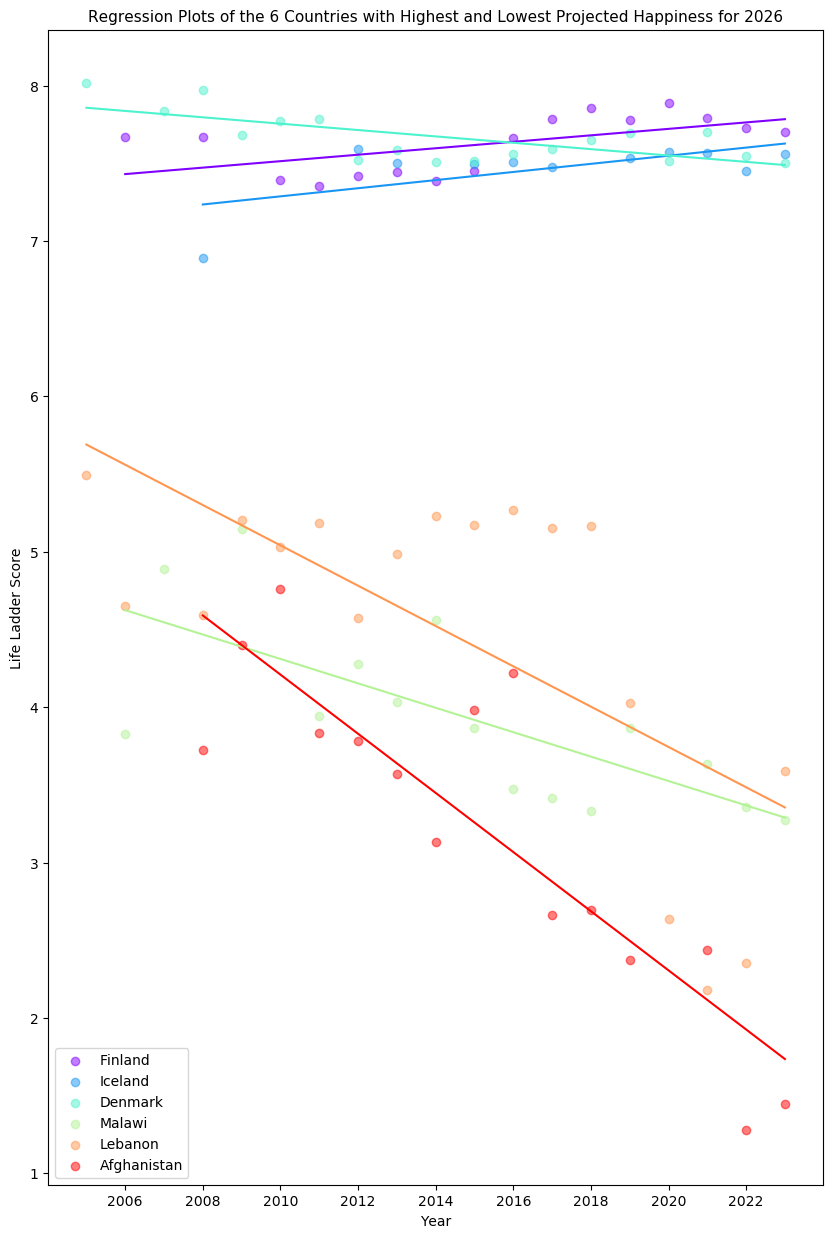

In [217]:
ploterooo(3, pt, "Regression Plots of the 6 Countries with Highest and Lowest Projected Happiness for 2026")

In [134]:
def ploteroo(x, y, df, title):
  country_list = df.head(x*y)['Country name'].to_list()
  fig, axes = plt.subplots(y, x, figsize=(20, 20))

  k = 0
  for i in range(y):
    for j in range(x):
      HapModel(country_list[k]).transform_axes(axes[i][j])
      k += 1

  fig.suptitle(title, fontsize=30)
  #plt.tight_layout()
  plt.show()

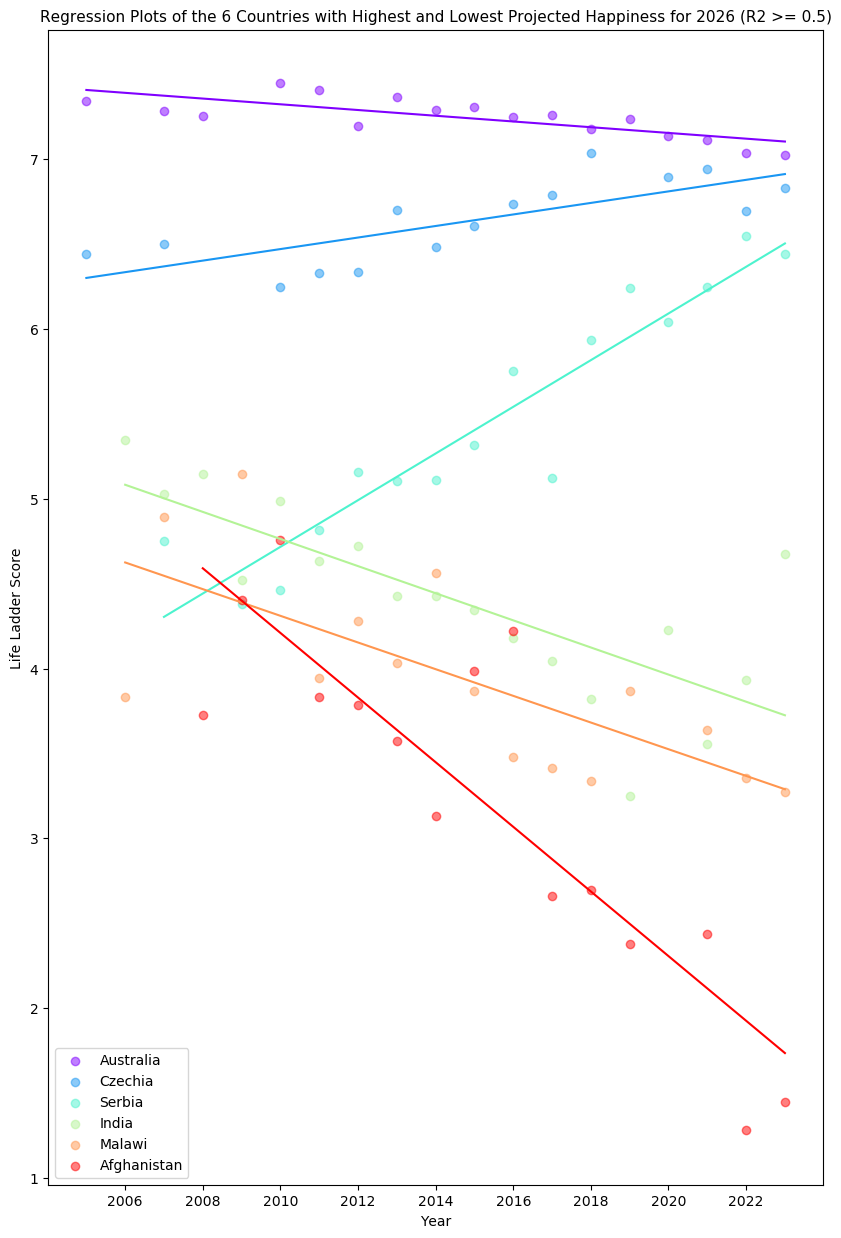

In [216]:
ploterooo(3, tpt, "Regression Plots of the 6 Countries with Highest and Lowest Projected Happiness for 2026 (R2 >= 0.5)")

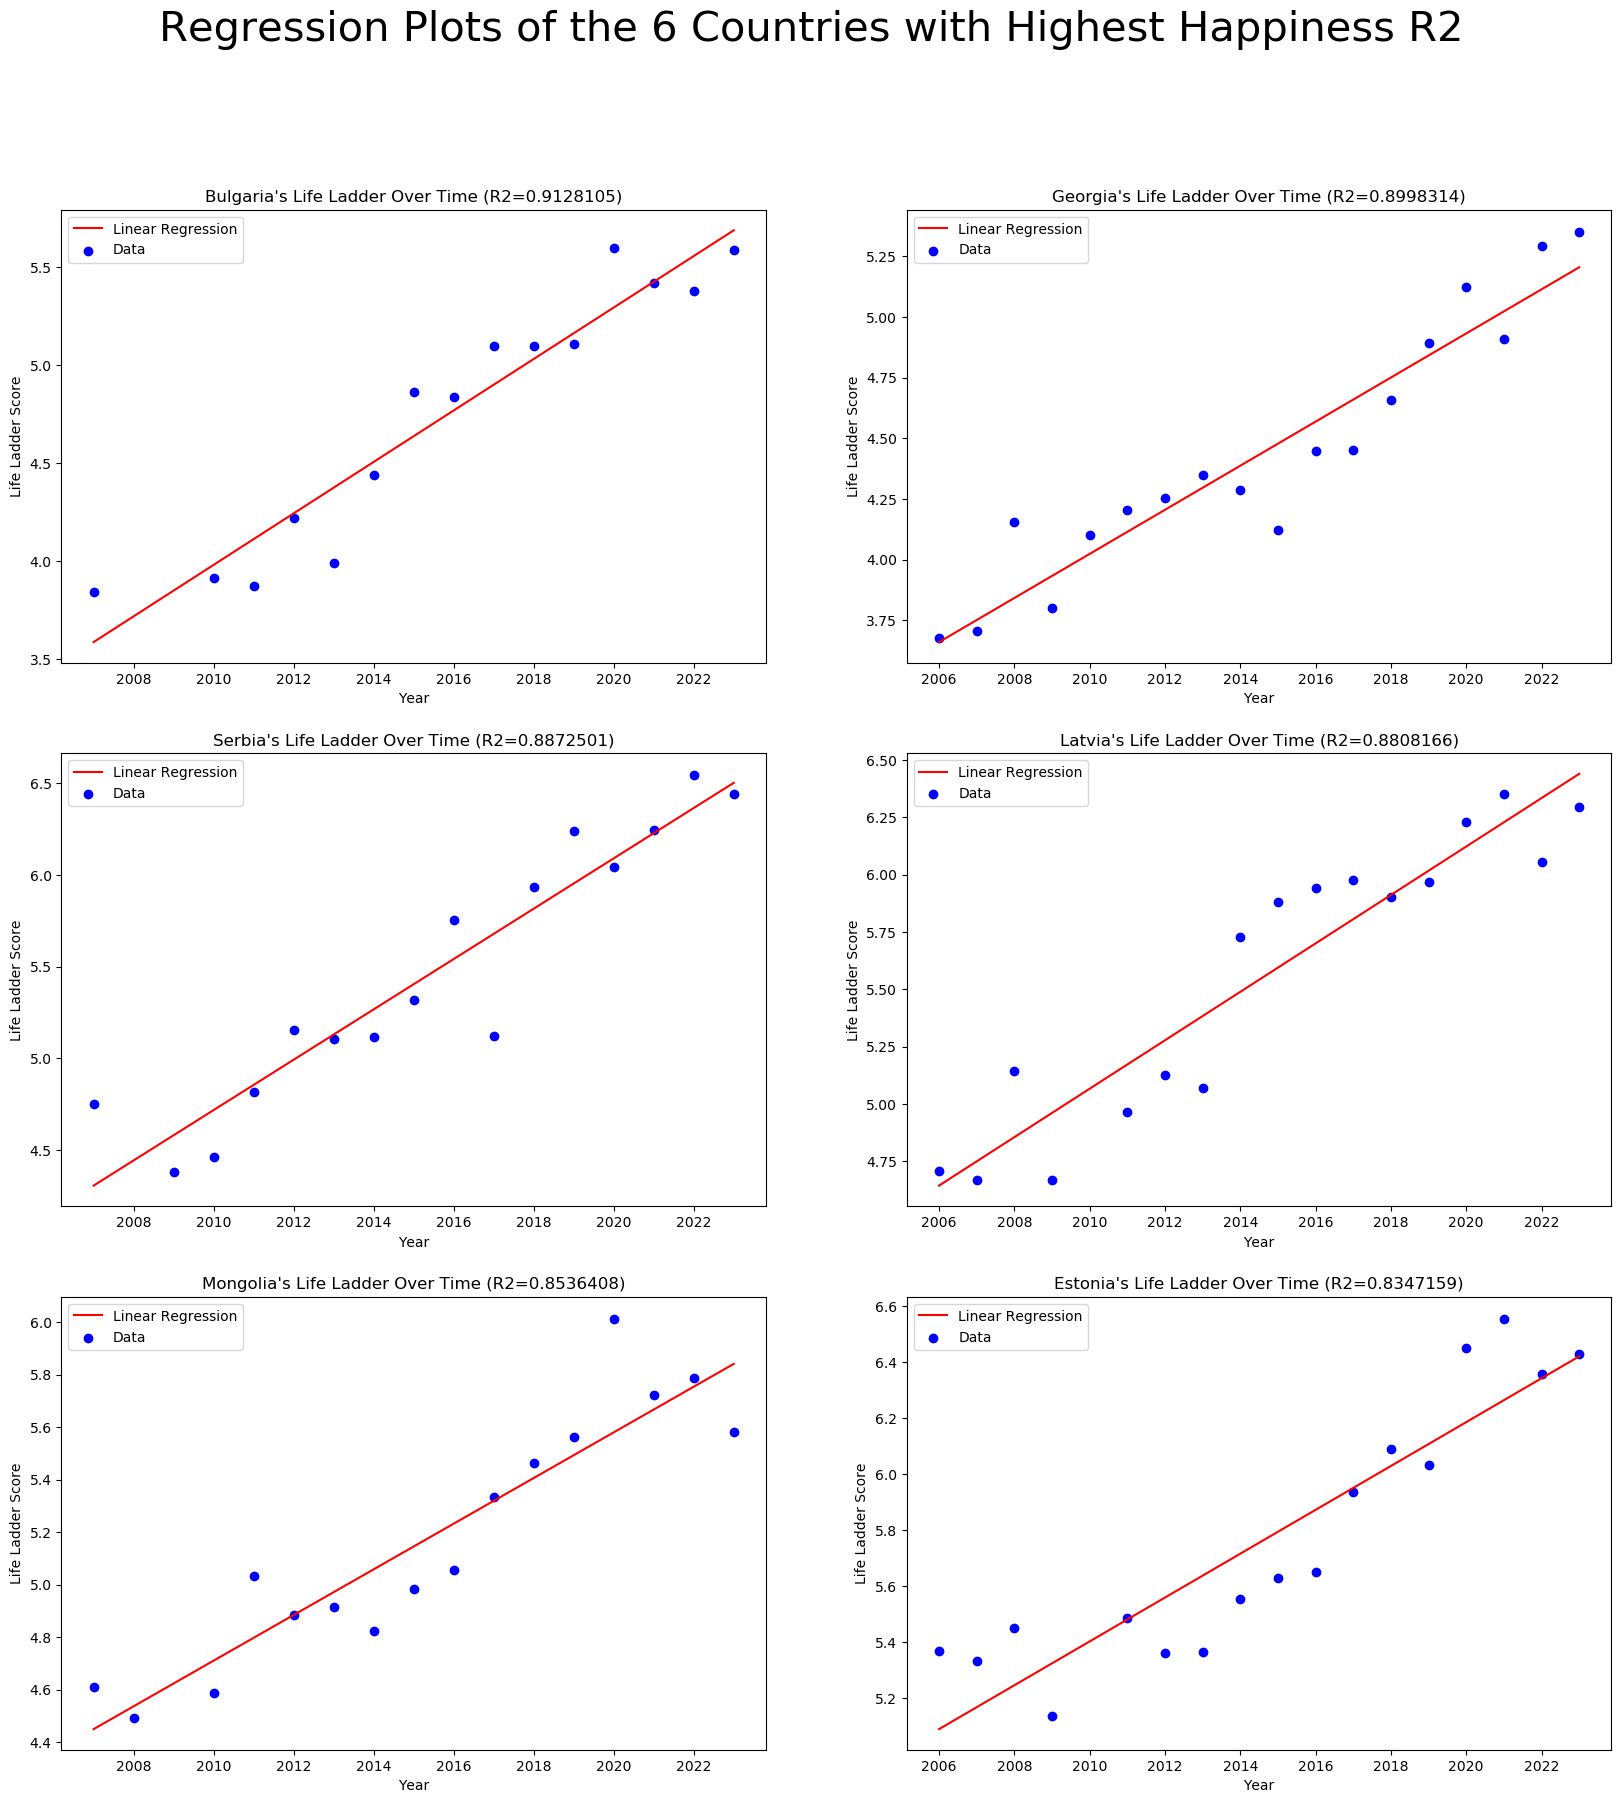

In [234]:
ploteroo(2, 3, rpt, "Regression Plots of the 6 Countries with Highest Happiness R2")

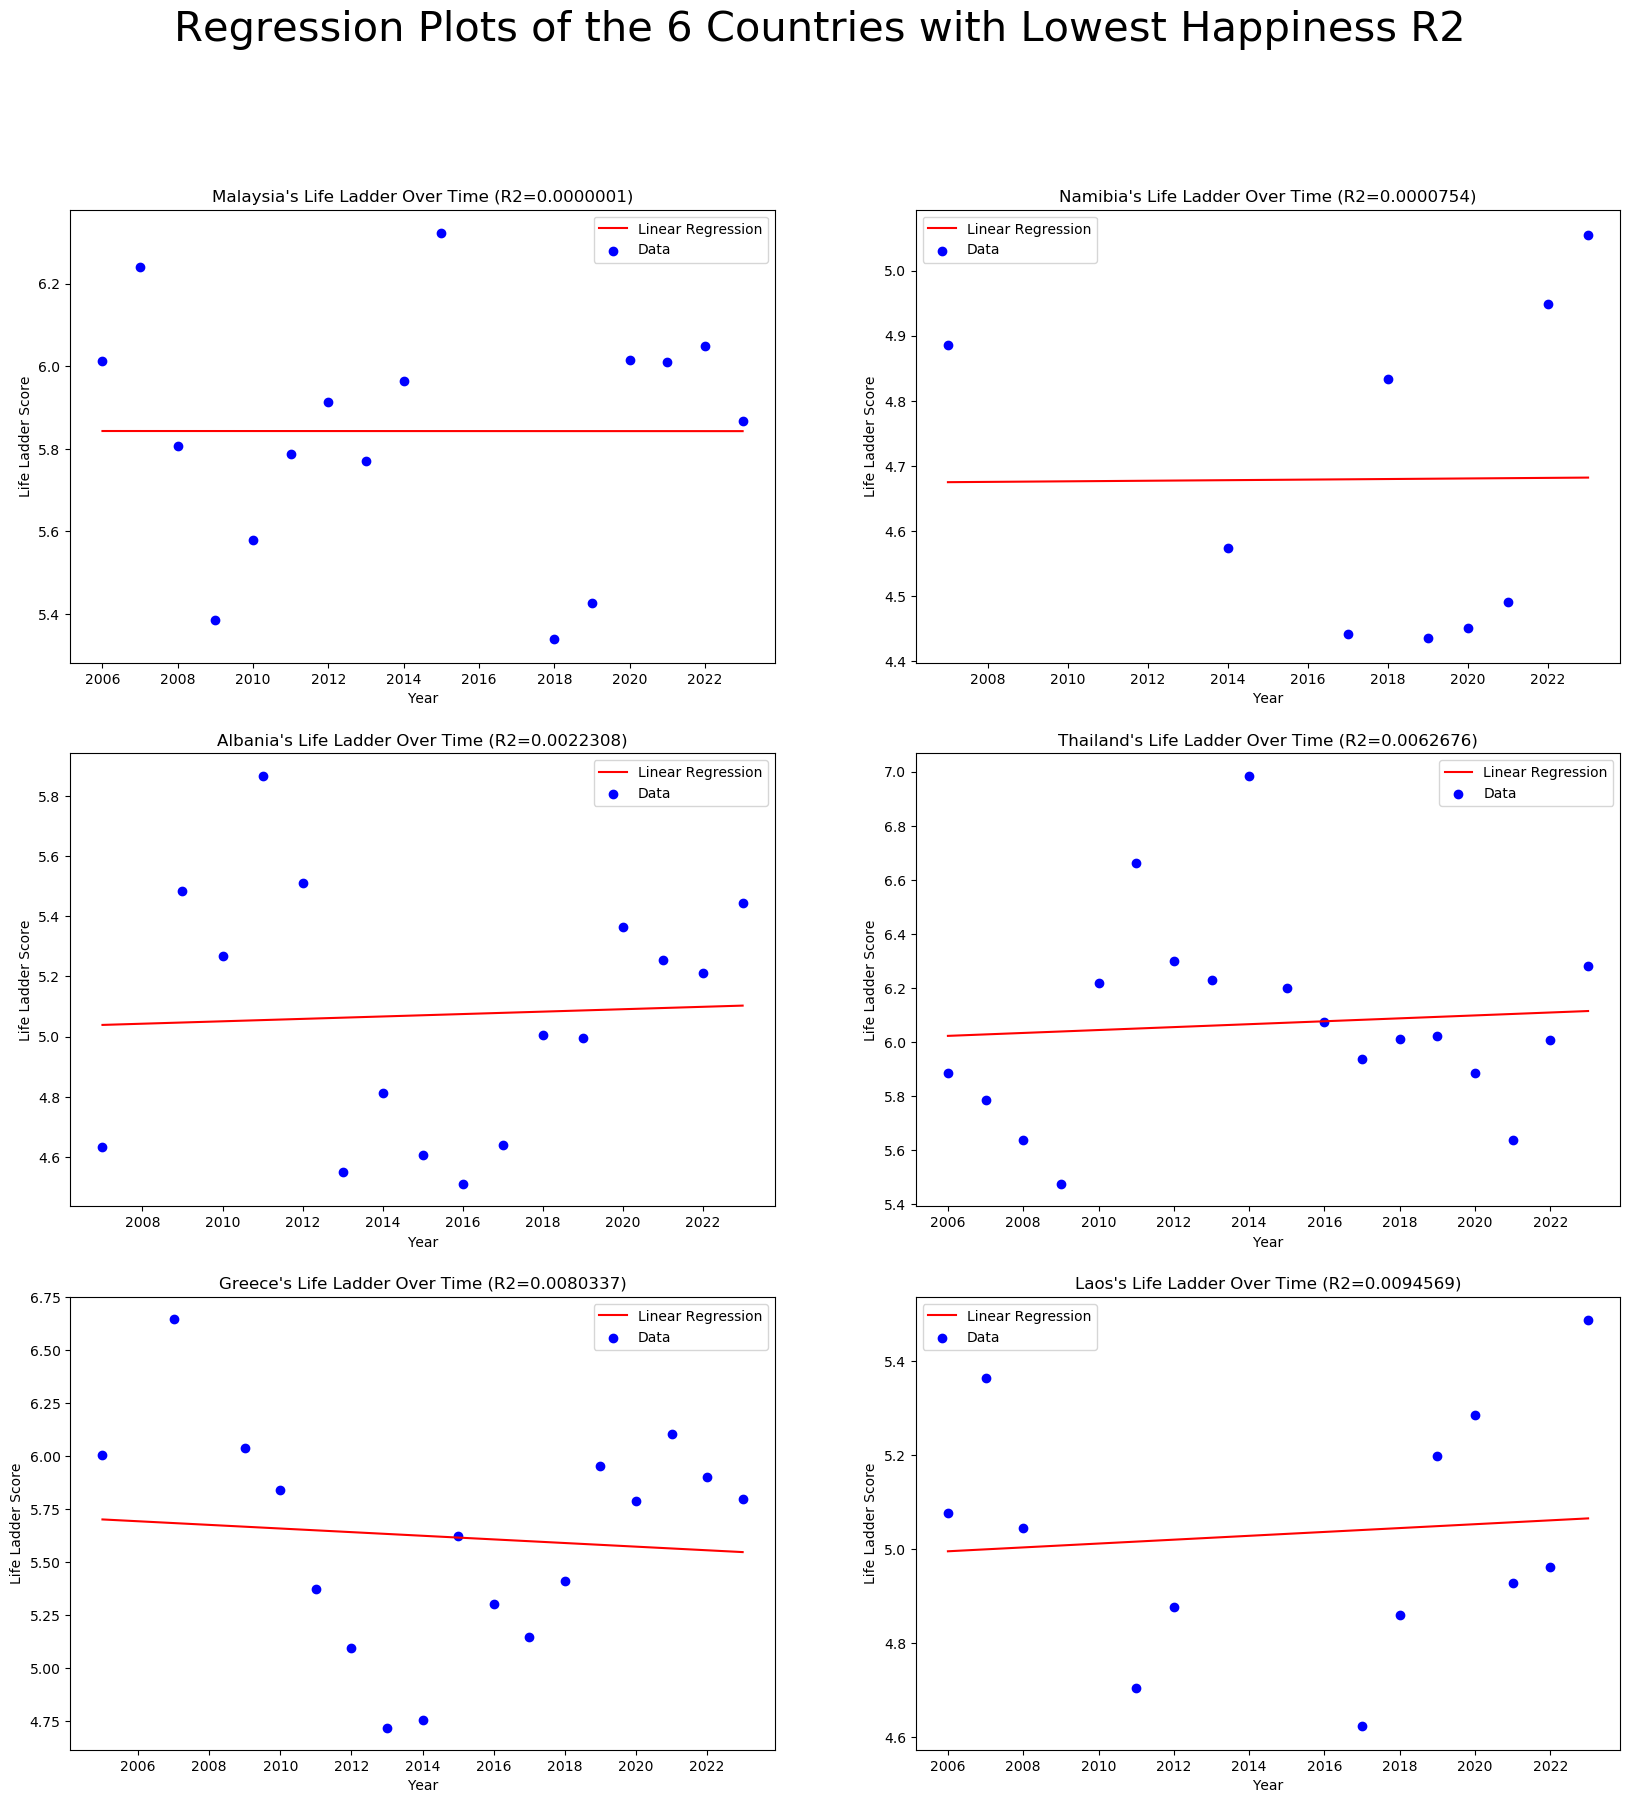

In [233]:
ploteroo(2, 3, rpt.iloc[::-1], "Regression Plots of the 6 Countries with Lowest Happiness R2")

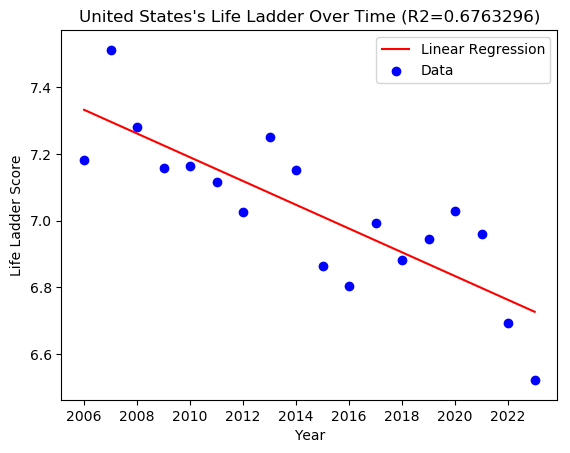

In 2026, United States's Life Ladder score is projected to be 6.61919877141213!


In [237]:
h1 = HapModel('United States')
h1.report()
h1.display_happy_pred(2026)

### Insights and Conclusions